In [12]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from data_analysis.helpers import *

312
311


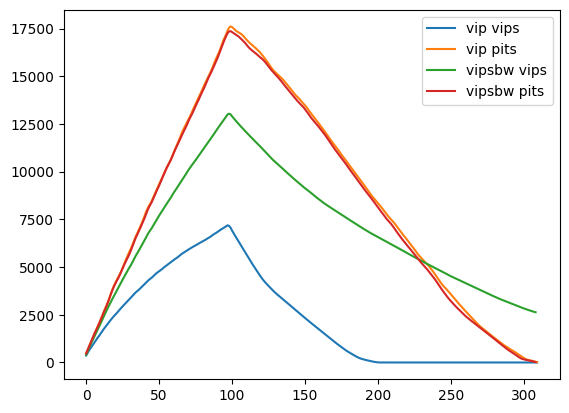

In [20]:
experiment_name = "some"
topology = "abilene"
config_path = "../sim_configs/" + experiment_name + "_config.json"
test_config = getTestConfig(config_path)
db_path = "../sim_outputs/" + experiment_name + "_" + topology + "_db.json"
db = getJsonDb(db_path)

case_filters = [
    ("num_objects", 1000, None),
    ("request_rate", 20, None),
    ("request_dist_param", 0.5, None),
    ("cache_capacities", (5,), None),
]

param_list = simConfigToParamSets(test_config)
param_list = filterParamList(param_list, case_filters)
fig, ax = plt.subplots()
for cache_pol in ["vip", "vipsbw"]:
    filters = [("cache_pol", cache_pol, None)]
    pol_param_list = filterParamList(param_list, filters)
    assert len(pol_param_list) == 1
    param_hash = str(hash(pol_param_list[0]))
    vips = singleEntrySumDataFieldAcrossNodes(
        topology,
        db[param_hash],
        "vip_count_sum",
    )
    pits = singleEntrySumDataFieldAcrossNodes(
        topology,
        db[param_hash],
        "pit_count_sum",
    )
    window_size = 3
    print(len(vips))
    vip_moving_avg = np.convolve(vips, np.ones(window_size) / window_size, mode="valid")
    ax.plot(vip_moving_avg, label=cache_pol + " vips")
    pit_moving_avg = np.convolve(pits, np.ones(window_size) / window_size, mode="valid")
    ax.plot(pit_moving_avg, label=cache_pol + " pits")

ax.legend()
plt.show()


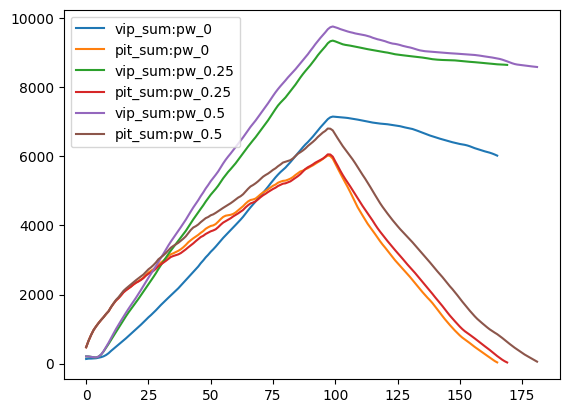

In [32]:
df = pd.read_json('/home/volkan/Repos/multi-tier/sim_outputs/sample_abilene_db.json')
column_dfs = [item[1] for item in df.items()]

fig = plt.figure()

labels = []

for column_df in column_dfs:
    if 'vip_count_sum' not in column_df['data']['0']:
        continue
    label_suffix = str(column_df['parameters']['pen_weight'])
    num_slots = int(column_df['data']['sim_time'])
    vip_count_acc = np.zeros(num_slots)
    pit_count_acc = np.zeros(num_slots)
    for key in range(11):
        if 'vip_count_sum' in column_df['data'][str(key)]:
            vip_count_acc += column_df['data'][str(key)]['vip_count_sum']
            pit_count_acc += column_df['data'][str(key)]['pit_count_sum']
    window_size = 3
    vip_moving_avg = np.convolve(vip_count_acc, np.ones(window_size)/window_size, mode='valid')
    plt.plot(vip_moving_avg, label="vip_sum:pw_"+label_suffix)
    labels.append("vip_sum:pw_"+label_suffix)
    pit_moving_avg = np.convolve(pit_count_acc, np.ones(window_size)/window_size, mode='valid')
    plt.plot(pit_moving_avg, label="pit_sum:pw_"+label_suffix)
    labels.append("pit_sum:pw_"+label_suffix)
    
plt.legend(labels=labels,loc='upper left')
plt.show()
